In [67]:
import numpy as np
import pandas as pd
import random
import torch
import dgl
import os
import sys

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 현재 파일의 상위 디렉토리를 sys.path에 추가
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [68]:
# 폰트 설정
import matplotlib as mpl
import matplotlib.font_manager as fm

font_path = r"C:\Windows\Fonts\malgun.ttf"  
font_prop = fm.FontProperties(fname=font_path)
mpl.rcParams['font.family'] = font_prop.get_name()
mpl.rcParams['axes.unicode_minus'] = False

In [69]:
# 재현성 난수 고정
def SET_SEED():
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    dgl.random.seed(SEED)

    os.environ['PYTHONHASHSEED'] = str(SEED)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 100
SET_SEED()

In [70]:
dataset = 'esol' # freesolv / esol / lipo
save_dir = r'..\results_figure\pca'

In [71]:
# # 상황분류
# df_class = pd.read_excel(r'..\datasets\vp_class3.xlsx')

# df_class.dropna(inplace = True)
# df_class['logvp'] = np.around(np.log(df_class['vapor pressure']), 2)
# df_class.reset_index(drop = True, inplace = True)
# df_class.head()

In [72]:
path = f'../datasets/{dataset}.csv'
df = pd.read_csv(path)
smiles_list = df['smiles'].tolist()

# target 정의
target = df.iloc[:,-1]

print(smiles_list[:5])
print(target[:5])

['OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O', 'Cc1occc1C(=O)Nc2ccccc2', 'CC(C)=CCCC(C)=CC(=O)', 'c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43', 'c1ccsc1']
0   -0.77
1   -3.30
2   -2.06
3   -7.87
4   -1.33
Name: logp, dtype: float64


In [73]:
from utils.utils import MolecularFeatureExtractor
# 분자 특성 추출 및 데이터프레임 정의
extractor = MolecularFeatureExtractor()
df_all_features = extractor.extract_molecular_features(smiles_list)

df_all_features['target'] = target
df_all_features

num_all_features = df_all_features.shape[1] - 1 
print("초기 변수 개수:", num_all_features)

# na handling
# NA 확인
df_all_features[df_all_features.isna().any(axis = 1)] # 행방향

# 결측치가 포함된 feature 개수
print('결측치가 포함된 열 개수:', df_all_features.isna().any(axis = 0).sum(), '\n')
print(df_all_features.isna().any(axis = 0))

print('결측치가 포함된 행 개수:', df_all_features.isna().any(axis = 1).sum(), '\n')
print(df_all_features.isna().any(axis = 1))

df_removed_features = df_all_features.dropna()

# 결측치가 포함된 feature 제거
# df_removed_features = df_all_features.dropna(axis = 1)
num_removed_features = df_removed_features.shape[1] - 1  # logvp 열 제외

print("제거 후 남은 feature 개수:", num_removed_features)

# 결측치가 제거된 data frame
df_removed_features

# 결측치가 포함된 feature 개수
print('결측치가 포함된 열 개수:', df_removed_features.isna().any(axis = 0).sum(), '\n')
print(df_removed_features.isna().any(axis = 0))

print('결측치가 포함된 행 개수:', df_removed_features.isna().any(axis = 1).sum(), '\n')
print(df_removed_features.isna().any(axis = 1))



# nunique == 1 인 경우는 제
unique_columns = list(df_removed_features.loc[:, df_removed_features.nunique() == 1].columns)
print('nunique == 1인 feature : \n', unique_columns, '\n')

# nunique == 1인 feature 제거
#df_removed_features.drop(columns = unique_columns, inplace = True)
df_removed_features = df_removed_features.drop(columns = unique_columns).copy()

num_removed_features = df_removed_features.shape[1] - 1  # logvp 열 제외

print("제거 후 남은 feature 개수:", num_removed_features, '\n')
print(df_removed_features.shape)


# 너무 낮은 vairnace를 가지는 경
low_variances = sorted(df_removed_features.var())
low_variances[:10]

columns_low_variances = []

for i in low_variances:
    if i < 0.001:
        column = df_removed_features.loc[:, df_removed_features.var() == i].columns
        columns_low_variances.append(column)
columns_low_variances = [item for index in columns_low_variances for item in index]

# 2. 중복 제거 및 유니크 값 추출
columns_low_variances = list(set(columns_low_variances))
print(columns_low_variances)

# 낮은 분산의 변수 제거
df_removed_features = df_removed_features.drop(columns = columns_low_variances).reset_index(drop=True).copy()
num_removed_features = df_removed_features.shape[1] - 1  # logvp 열 제외

print("제거 후 남은 feature 개수:", num_removed_features, '\n')
print(df_removed_features.shape)

df_removed_features

초기 변수 개수: 208
결측치가 포함된 열 개수: 0 

MaxEStateIndex       False
MinEStateIndex       False
MaxAbsEStateIndex    False
MinAbsEStateIndex    False
qed                  False
                     ...  
fr_thiocyan          False
fr_thiophene         False
fr_unbrch_alkane     False
fr_urea              False
target               False
Length: 209, dtype: bool
결측치가 포함된 행 개수: 0 

0       False
1       False
2       False
3       False
4       False
        ...  
1123    False
1124    False
1125    False
1126    False
1127    False
Length: 1128, dtype: bool
제거 후 남은 feature 개수: 208
결측치가 포함된 열 개수: 0 

MaxEStateIndex       False
MinEStateIndex       False
MaxAbsEStateIndex    False
MinAbsEStateIndex    False
qed                  False
                     ...  
fr_thiocyan          False
fr_thiophene         False
fr_unbrch_alkane     False
fr_urea              False
target               False
Length: 209, dtype: bool
결측치가 포함된 행 개수: 0 

0       False
1       False
2       False
3       False
4     

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,...,fr_pyridine,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,target
0,10.253329,-1.701605,10.253329,0.486602,0.217518,457.432,430.216,457.158411,178,0.188266,...,0,0,0,0,0,0,0,0,0,-0.770
1,11.724911,-0.145880,11.724911,0.145880,0.811283,201.225,190.137,201.078979,76,0.258698,...,0,0,0,0,0,0,0,0,0,-3.300
2,10.020498,0.845090,10.020498,0.845090,0.343706,152.237,136.109,152.120115,62,0.142281,...,0,0,0,0,0,0,0,0,0,-2.060
3,2.270278,1.301055,2.270278,1.301055,0.291526,278.354,264.242,278.109550,102,-0.009873,...,0,0,0,0,0,0,0,0,0,-7.870
4,2.041667,1.712963,2.041667,1.712963,0.448927,84.143,80.111,84.003371,26,-0.009338,...,0,0,0,0,0,0,1,0,0,-1.330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,10.999421,-4.317901,10.999421,1.916667,0.523506,197.381,196.373,195.890224,44,0.414120,...,0,0,0,0,0,0,0,0,0,-1.710
1124,11.337508,-0.705457,11.337508,0.123704,0.293876,219.266,206.162,219.067762,80,0.432627,...,0,1,0,0,0,0,0,0,0,0.106
1125,5.174287,-1.984662,5.174287,1.011373,0.506070,246.359,231.239,245.997179,74,0.246324,...,0,1,0,0,0,0,0,2,0,-3.091
1126,2.222222,0.884259,2.222222,0.884259,0.444441,72.151,60.055,72.093900,32,-0.047395,...,0,0,0,0,0,0,0,0,0,-3.180


# tSNE & PCA

In [74]:
# target split
target = df_removed_features.iloc[:,-1]

# 1/3
med1 = np.percentile(target, 33)
med2 = np.percentile(target, 66)
low = np.where(target < med1)[0]
mid = np.where((target >= med1) & (target < med2))[0]
high = np.where(target >= med2)[0]

In [75]:
X = np.array(df_removed_features.drop(columns = ['target']))
X.shape

(1128, 183)

In [76]:
PCA_model2D = PCA(n_components = 2)
PCA_model3D = PCA(n_components = 3)

scaler = StandardScaler()

X_scaling = scaler.fit_transform(X)

X_pca2D = PCA_model2D.fit_transform(X_scaling)
X_pca3D = PCA_model3D.fit_transform(X_scaling)

..\results_figure\pca\pca_esol.png


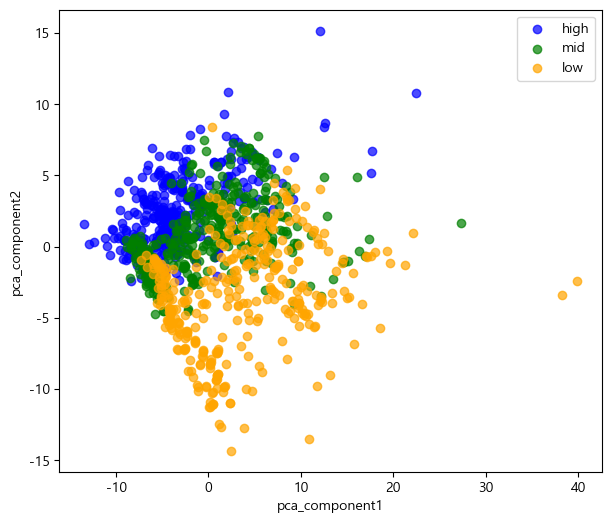

In [77]:
# 3등분 2D
# pca
fig = plt.figure(figsize=(7, 6))
ax2 = fig.add_subplot(111)

ax2.scatter(X_pca2D[high, 0], X_pca2D[high, 1], label='high', c='blue', alpha=0.7)
ax2.scatter(X_pca2D[mid, 0], X_pca2D[mid, 1], label='mid', c='green', alpha=0.7)
ax2.scatter(X_pca2D[low, 0], X_pca2D[low, 1], label='low', c='orange', alpha=0.7)

ax2.set_xlabel('pca_component1')
ax2.set_ylabel('pca_component2')
ax2.legend()

# 저장
# os.chdir(r'C:\Programming\Github\Project\ChemGCNs') # pcrl
file_name = f'pca_{dataset}.png'
file_path = os.path.join(save_dir, file_name)
print(file_path)
plt.savefig(file_path, dpi = 600, bbox_inches = 'tight')

plt.show()